In [2]:
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import matplotlib.pyplot as plt
import warnings as wgs
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import PolynomialFeatures 
wgs.filterwarnings('ignore')
% matplolib notebook


UsageError: Line magic function `%` not found.


In [3]:
url=urlopen("https://www.insee.fr/fr/statistiques/6436488#tableau-petrole-g1-fr")

In [ ]:
REG=bs(url,'html')
print(REG.prettify())

In [5]:
h=REG.find('thead')
Titre=h.text.strip().split('\n')
title=[]
title.append('Date')
title.append(Titre[0])
title.append(Titre[1])
title

['Date', 'Prix en devises', 'Prix en euros']

In [6]:
t=REG.find_all('tbody')
M=[]
for j in t[1]:
    M.append(j.text.strip().split('\n'))


In [7]:
D=pd.DataFrame(M)
D.dropna(inplace=True)
D.columns=title
data=D.copy()
data['Date']=D['Date'].astype('datetime64')
data[title[1:]]=D[title[1:]].astype(float)
data.sort_index(ascending=False,inplace=True)
data.set_index('Date',inplace=True)
data.to_csv("importation_petrole.csv")


In [8]:
# Moyenne fixe sur les périodes antérieures
data["Prix en euros"].mean()

57.218018018018014

In [ ]:
data

<AxesSubplot:xlabel='Prix en euros'>

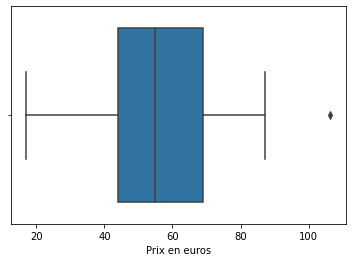

In [10]:
# Boxplot
sns.boxplot(x=data["Prix en euros"])

On retrouve bien une moyenne d'environ 57.21 euros du prix du Brente de petrole aucours de Janvier 2013 à Mars 2022 

In [ ]:
##### Nuage de points
plt.figure(figsize=(16,8))
plt.scatter(x=D["Date"].sort_index(ascending=False),y=data["Prix en euros"].sort_index(ascending=True))


<AxesSubplot:xlabel='Prix en euros', ylabel='Count'>

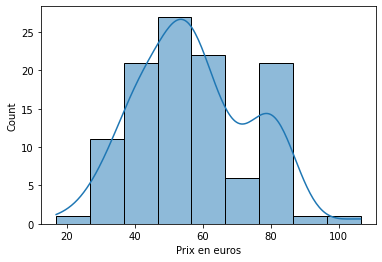

In [12]:
# Histogramme
sns.histplot(data["Prix en euros"],kde=True)

In [ ]:
# Prix du pétrole en euro
data["Prix en euros"].plot(figsize=(14,5))
data.sort_index(ascending=False,inplace=True)


In [14]:
#Fonction permettant d'éxécuter les deux test
def get_stationarity(timeseries):
    
    #Statistiques mobiles 
    # calculer la moyenne roulante pour notre df
    rolling_mean = timeseries.rolling(window = 4).mean()
    # calculer l'Ecart-type roulant pour notre df
    rolling_std = timeseries.rolling(window = 4).std()

    # Visulaiser les statistiques mobiles
    plt.plot(timeseries, color='blue', label= 'Origine')
    plt.plot(rolling_mean, color='red', label ='Moyenne mobile')
    plt.plot(rolling_std, color='black', label ='Ecart-type mobile')

    plt.legend(loc='best')
    plt.title('Statistiques roulantes')
    plt.show(block= False)
    
    # Test Dickey-Fuller
    result = adfuller(timeseries,autolag='AIC')
    print('Statistiques ADF : {}'.format(result[0]))
    print('p-value : {}'.format(result[1]))
    print('Valeurs Critiques :')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

In [ ]:
r=data['Prix en euros']-data['Prix en euros'].rolling(window=4).mean()
r.dropna(inplace=True)
get_stationarity(r)
    

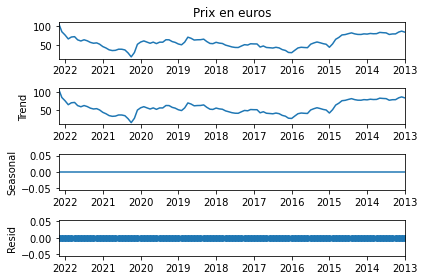

In [16]:
# Décomposition Erreur-saisonnalité-Tendance
seasonal_decompose(data["Prix en euros"], model='additive', freq=1).plot();

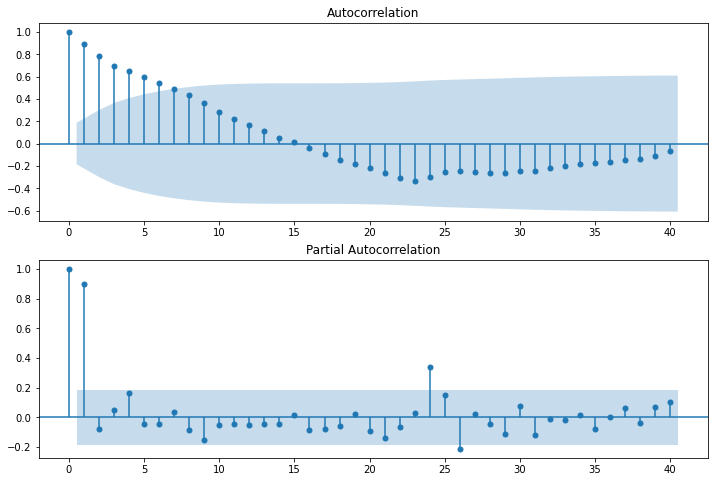

In [17]:

iport matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data['Prix en euros'], lags=40, ax=ax1,)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data['Prix en euros'], lags=40, ax=ax2);

In [ ]:
from pmdarima import auto_arima
steps=auto_arima(data['Prix en euros'],start_p=0,start_q=0,max_p=8,max_q=8, seasonal=False,trace=True);
steps.summary()

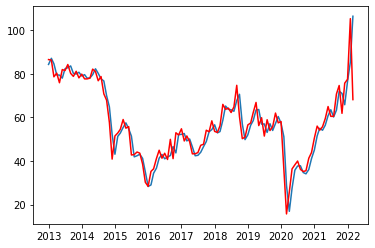

In [29]:
model = ARIMA(data['Prix en euros'], order = (1,0,1))
results = model.fit()
plt.plot(data['Prix en euros'])
plt.plot(results.fittedvalues, color='red')

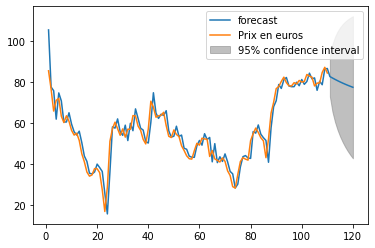

In [30]:
results.plot_predict(1,120);

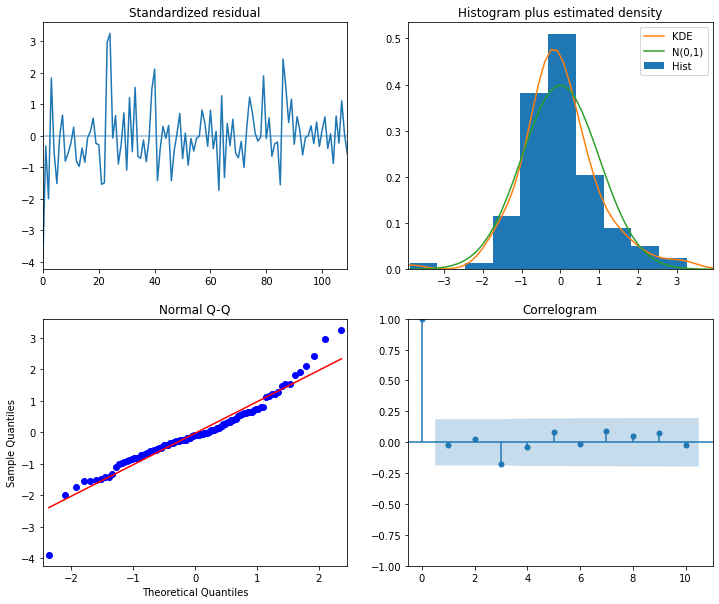

In [32]:
steps.plot_diagnostics(figsize=(12, 10))
plt.show()


In [43]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(steps.resid(),lags=[10], return_df=True)


,lb_stat,lb_pvalue
10,5.621739,0.845979


La p_value est de 0.845979 donc le modèle est pertinent pour la pédiction
